# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

- 17 campaigns
- Offer long-term deposit with special, beneficial interest rate because of decreasing solvency during recession
- Customers can be contacted by more than one campaign

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [135]:
# Import necessary libraries
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from sklearn.compose import ColumnTransformer
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.simplefilter(action='ignore')


In [136]:
# Import the dataset
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [137]:
# Check for duplicates
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [138]:
# Check unique values 
unique_values_list = []
uniq_cnt = []
data_list = []
col_list = []
cntr = 1
for i in df.columns:
    unique_values_list.append({i: df[i].unique()})
    uniq_cnt.append(len(df[i].unique()))
    col_list.append(i)
    data_list.append(df[i].dtype)
    cntr += 1

# Build table of information regarding the unique values
print(len(uniq_cnt))
unique_df = pd.DataFrame(data=uniq_cnt, index=col_list, columns={0: 'unique_count'})
unique_df.rename({0: 'unique_counts'}, axis = 1, inplace=True)
unique_df['data_type'] = data_list
unique_df.head(30)

21


,unique_counts,data_type
age,78,int64
job,12,object
marital,4,object
education,8,object
default,3,object
housing,3,object
loan,3,object
contact,2,object
month,10,object
day_of_week,5,object


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Average age: 40.01985884643466


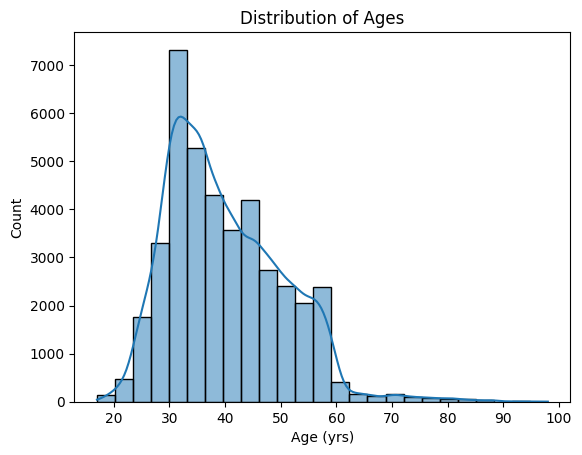

In [168]:
# Plot for the only properly continuous variable in the dataset, age
sns.histplot(df['age'], bins = 25, kde=True, stat = 'count').set_title('Distribution of Ages')
plt.xlabel('Age (yrs)')
print(f'Average age: {df['age'].mean()}')

[Text(0.5, 1.0, 'Socioeconomic Indicators')]

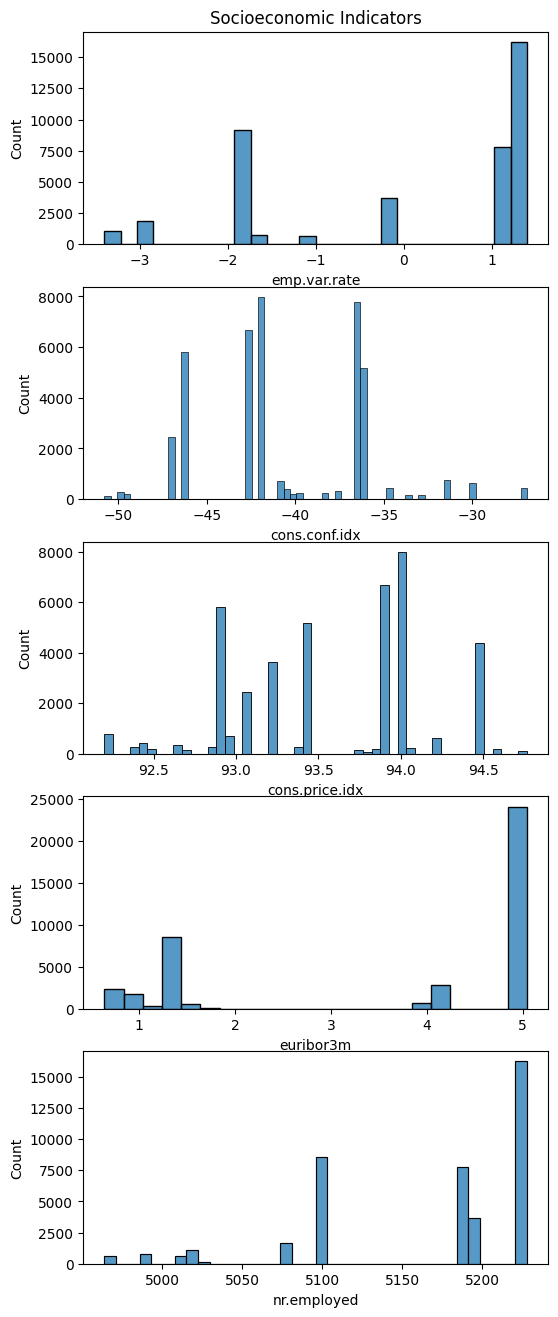

In [140]:
# Figure with subplots to visualize socioeconomic indicator metrics
fig, axes = plt.subplots(ncols = 1, nrows = 5, figsize = (6, 16))
sns.histplot(df['emp.var.rate'], ax = axes[0])
sns.histplot(df['cons.conf.idx'], ax = axes[1])
sns.histplot(df['cons.price.idx'], ax = axes[2])
sns.histplot(df['euribor3m'], ax = axes[3])
sns.histplot(df['nr.employed'], ax = axes[4])
axes[0].set(title = 'Socioeconomic Indicators')

[Text(0.5, 0, 'loan default')]

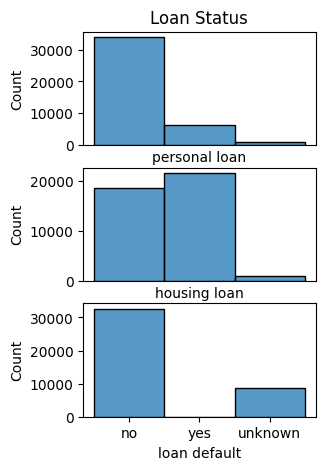

In [141]:
# Create a dataframe for visualization purposes of categorical variables
plot_df = df.copy()
plot_df['loan'] = pd.Categorical(plot_df['loan'], ['no','yes','unknown'])
plot_df['housing'] = pd.Categorical(plot_df['housing'], ['no','yes','unknown'])
plot_df['default'] = pd.Categorical(plot_df['default'], ['no','yes','unknown'])

# Generate subplot figure for the distributions of factors related to loan statuses
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (3, 5)) #figsize = ...
sns.histplot(plot_df['loan'], ax = axes[0])
sns.histplot(plot_df['housing'], ax = axes[1])
sns.histplot(plot_df['default'], ax = axes[2])
axes[0].set(xlabel='personal loan', xticks = [], xticklabels = [], title = 'Loan Status')
axes[1].set(xlabel='housing loan', xticks = [], xticklabels = [])
axes[2].set(xlabel='loan default')

[Text(0.5, 0, 'education')]

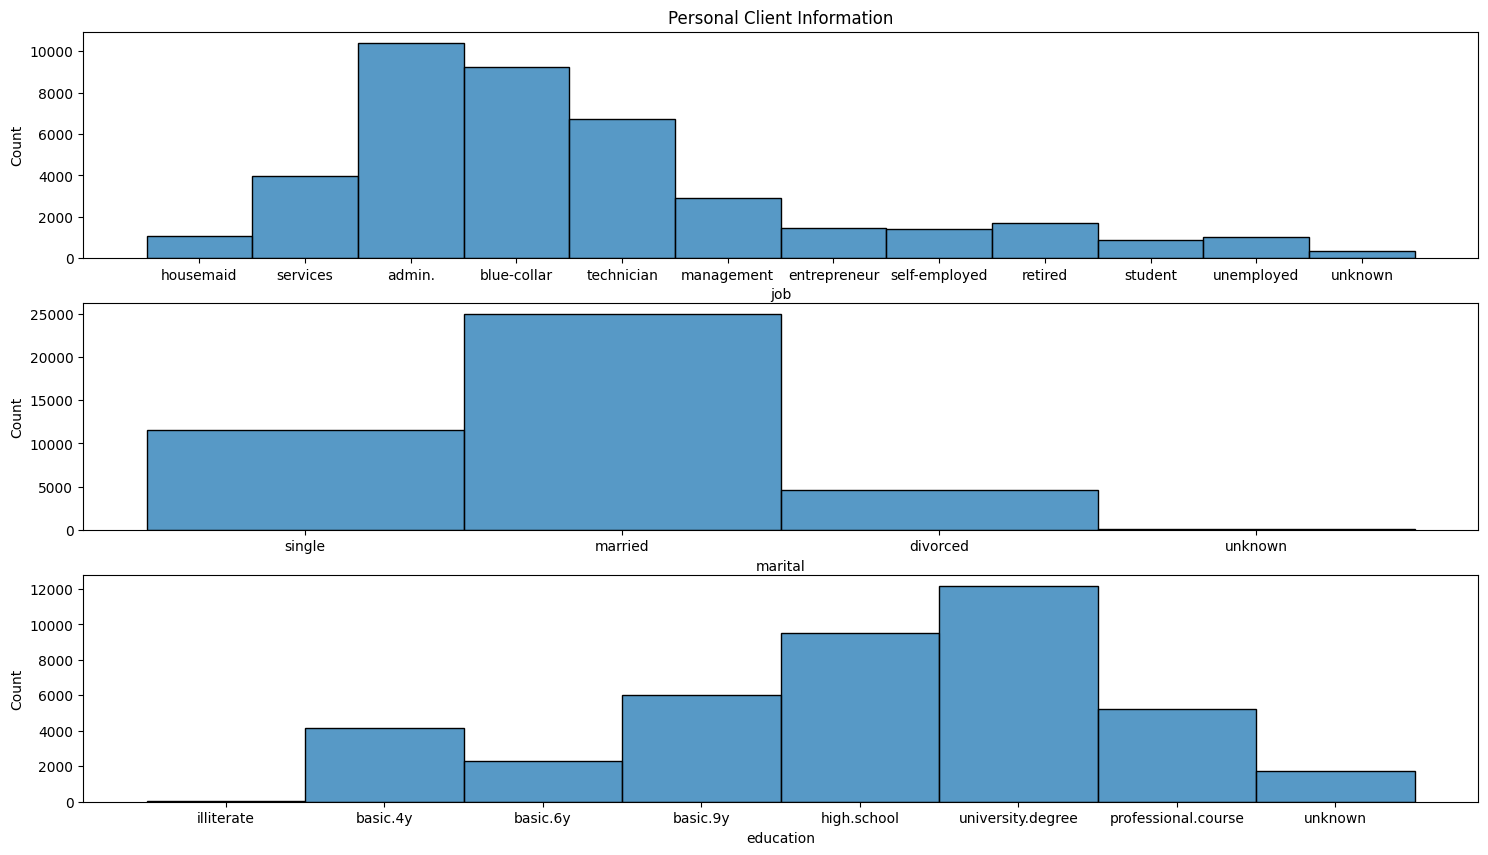

In [142]:
# Create categorical variables for visualization purposes (arbitrary order for job, unknown last)
plot_df = df.copy()
plot_df['job'] = pd.Categorical(plot_df['job'], ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'management',
                                                 'entrepreneur', 'self-employed', 'retired', 'student', 'unemployed', 'unknown'])
plot_df['marital'] = pd.Categorical(plot_df['marital'], ['single', 'married', 'divorced', 'unknown'])
plot_df['education'] = pd.Categorical(plot_df['education'], ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
                                                             'university.degree', 'professional.course', 'unknown'])

# Generate subplot figure for personal client information
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (18, 10)) #figsize = ...
sns.histplot(plot_df['job'], ax = axes[0])
sns.histplot(plot_df['marital'], ax = axes[1])
sns.histplot(plot_df['education'], ax = axes[2])
axes[0].set(xlabel='job', title = 'Personal Client Information')
axes[1].set(xlabel='marital')
axes[2].set(xlabel='education')

[Text(0.5, 0, 'month')]

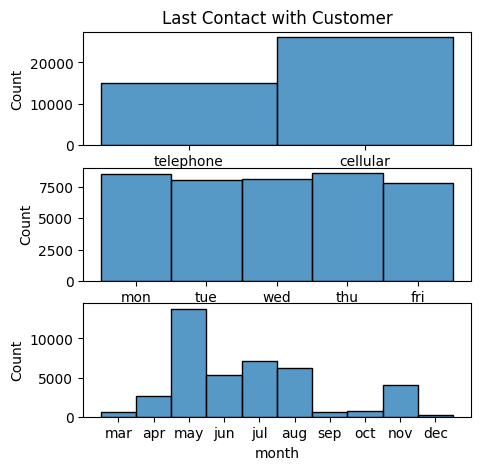

In [143]:
# Create categorical variable for month to ensure proper order in visualization
plot_df = df.copy()
plot_df['month'] = pd.Categorical(plot_df['month'], ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

# Generate subplots for information related to the last contact with customer
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (5, 5)) #figsize = ...
sns.histplot(plot_df['contact'], ax = axes[0])
sns.histplot(plot_df['day_of_week'], ax = axes[1])
sns.histplot(plot_df['month'], ax = axes[2])
axes[0].set(xlabel='contact',title = 'Last Contact with Customer')
axes[1].set(xlabel='day_of_week')
axes[2].set(xlabel='month')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective: Identify essential factors for predicting whether a client will accept the long-term deposit offer and characterize the relationship between basic client attributes and their acceptance/rejection choice

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

```
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
```

In [144]:
# Translate target into numeric value
df['y'].replace({'yes': 1, 'no': 0}, inplace = True)

# Drop illiterate class for education and unknown class for marital due to lacking samples
df = df.drop(df[df['education'] == 'illiterate'].index)
df = df.drop(df[df['marital'] == 'unknown'].index)

# Translate education categories into the corresponding numnber of years of study
df['education'].replace({'unknown': 0, 'basic.4y': 4, 'basic.6y': 6, 'basic.9y': 9,
                         'high.school': 12, 'university.degree': 16, 'professional.course': 20}, inplace = True)

# Create separate data frame for the simple model that will be used for reference and comparison
simple_df = df[['age','job','marital','education','default','housing','loan','y']]

In [145]:
# MEstimateEncoder used instead of OneHotEncoder for computation and interpretation purposes, both encoders yield equivalent results
column_transformer = ColumnTransformer(
    [('mestimate', MEstimateEncoder(), ['marital','default','housing','loan','job']),
     ('scale', StandardScaler(), ['age'])],
     remainder = 'passthrough')

In [146]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,4,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,12,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,12,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,6,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,12,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [147]:
# The entire dataset used for a baseline using the dummy classifier (excluding duration)
X_ini_train, X_ini_test, y_ini_train, y_ini_test = train_test_split(df.drop(['y', 'duration'], axis = 1), df['y'], test_size = 0.2, random_state = 42)

# The duration column used as a secondary baseline model (benchmark purposes)
X_dur_train, X_dur_test, y_dur_train, y_dur_test = train_test_split(df[['duration']], df['y'], test_size = 0.2, random_state = 42)

# The 7 factors isolated in Problem 5 used for a simplified model
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(simple_df.drop('y', axis = 1), simple_df['y'], test_size = 0.2, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

- **F1 score will be the evaluation metric used throughout the project**
- **F1 score was chosen due to the inconsistency in target classes, and our preference for determining what variables are related to accepting the long-term deposit offer**
- Use dummy classifier (with full dataset)
- Duration baseline model is based solely on the duration factor, which is excluded from all other models

In [148]:
# The dummy classifier is our initial baseline model
start_time = time.time()
dummy_clf = DummyClassifier().fit(X_ini_train, y_ini_train)
dummy_time = (time.time() - start_time)
baseline_train_f1 = f1_score(y_ini_train, dummy_clf.predict(X_ini_train))
baseline_test_f1 = f1_score(y_ini_test, dummy_clf.predict(X_ini_test))

In [149]:
## The duration secondary baseline model used for benchmark purposes with all 4 classifiers
# Test LGR classifier
start_time = time.time()
dur_lgr = Pipeline([('scale', StandardScaler()),('lgr', LogisticRegression())]).fit(X_dur_train, y_dur_train)
dur_lgr_time = (time.time() - start_time)
dur_lgr_train_f1 = f1_score(y_dur_train, dur_lgr.predict(X_dur_train))
dur_lgr_test_f1 = f1_score(y_dur_test, dur_lgr.predict(X_dur_test))

# Test Decision tree classifier
start_time = time.time()
dur_tree = Pipeline([('scale', StandardScaler()),('tree', DecisionTreeClassifier())]).fit(X_dur_train, y_dur_train)
dur_tree_time = (time.time() - start_time)
dur_tree_train_f1 = f1_score(y_dur_train, dur_tree.predict(X_dur_train))
dur_tree_test_f1 = f1_score(y_dur_test, dur_tree.predict(X_dur_test))

# Test k nearest neighbors classifier
start_time = time.time()
dur_knn = Pipeline([('scale', StandardScaler()),('knn', KNeighborsClassifier())]).fit(X_dur_train, y_dur_train)
dur_knn_time = (time.time() - start_time)
dur_knn_train_f1 = f1_score(y_dur_train, dur_knn.predict(X_dur_train))
dur_knn_test_f1 = f1_score(y_dur_test, dur_knn.predict(X_dur_test))

# Test support vector machine classifier
start_time = time.time()
dur_svm = Pipeline([('scale', StandardScaler()),('svm', SVC())]).fit(X_dur_train, y_dur_train)
dur_svm_time = (time.time() - start_time)
dur_svm_train_f1 = f1_score(y_dur_train, dur_svm.predict(X_dur_train))
dur_svm_test_f1 = f1_score(y_dur_test, dur_svm.predict(X_dur_test))

In [150]:
# Build table for baseline model performance
baseline_df = pd.DataFrame({'Model': ['dummy', 'dur lgr', 'dur tree', 'dur knn', 'dur svm'],
                            'Train Time': [dummy_time, dur_lgr_time, dur_tree_time, dur_knn_time, dur_svm_time],
                            'Train F1': [baseline_train_f1, dur_lgr_train_f1, dur_tree_train_f1, dur_knn_train_f1, dur_svm_train_f1],
                            'Test F1': [baseline_test_f1, dur_lgr_test_f1, dur_tree_test_f1, dur_knn_test_f1, dur_svm_test_f1]})
baseline_df

,Model,Train Time,Train F1,Test F1
0,dummy,0.001376,0.000000,0.000000
1,dur lgr,0.012750,0.248788,0.288678
2,dur tree,0.026361,0.355020,0.238176
3,dur knn,0.008049,0.391963,0.307469
4,dur svm,6.296698,0.273455,0.304422


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [151]:
# Test the LGR model with the simplified data set
lgr_pipe = Pipeline([('transformer', column_transformer),
                     ('lgr', LogisticRegression())])
start_time = time.time()
lgr_pipe.fit(X_simple_train, y_simple_train)
lgr_time = (time.time() - start_time)


### Problem 9: Score the Model

What is the accuracy of your model?

In [152]:
# Evaluate performance of LGR model with F1 score
lgr_train_f1 = f1_score(y_simple_train, lgr_pipe.predict(X_simple_train))
lgr_test_f1 = f1_score(y_simple_test, lgr_pipe.predict(X_simple_test))

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [153]:
# Evaluate performance of decision tree classifier on simplified data set with f1 score
tree_pipe = Pipeline([('transformer', column_transformer),
                     ('tree', DecisionTreeClassifier())])
start_time = time.time()
tree_pipe.fit(X_simple_train, y_simple_train)
tree_time = (time.time() - start_time)
tree_train_f1 = f1_score(y_simple_train, tree_pipe.predict(X_simple_train))
tree_test_f1 = f1_score(y_simple_test, tree_pipe.predict(X_simple_test))

# Evaluate performance of k nearest neighbors classifier on simplified data set with f1 score
knn_pipe = Pipeline([('transformer', column_transformer),
                     ('knn', KNeighborsClassifier())])
start_time = time.time()
knn_pipe.fit(X_simple_train, y_simple_train)
knn_time = (time.time() - start_time)
knn_train_f1 = f1_score(y_simple_train, knn_pipe.predict(X_simple_train))
knn_test_f1 = f1_score(y_simple_test, knn_pipe.predict(X_simple_test))

# Evaluate performance of support vector machine classifier on simplified data set with f1 score
svm_pipe = Pipeline([('transformer', column_transformer),
                     ('svm', SVC())])
start_time = time.time()
svm_pipe.fit(X_simple_train, y_simple_train)
svm_time = (time.time() - start_time)
svm_train_f1 = f1_score(y_simple_train, svm_pipe.predict(X_simple_train))
svm_test_f1 = f1_score(y_simple_test, svm_pipe.predict(X_simple_test))

simple_result_df = pd.DataFrame({'Model': ['lgr', 'tree', 'knn', 'svm'], 'Train Time': [lgr_time, tree_time, knn_time, svm_time],
                                 'Train F1': [lgr_train_f1, tree_train_f1, knn_train_f1, svm_train_f1],
                                 'Test F1': [lgr_test_f1, tree_test_f1, knn_test_f1, svm_test_f1]})

In [154]:
# Create dataframe from performance results on simplified data set
simple_result_df.head()

,Model,Train Time,Train F1,Test F1
0,lgr,0.110517,0.000000,0.000000
1,tree,0.106289,0.433197,0.137490
2,knn,0.079728,0.229202,0.121973
3,svm,3.555163,0.000000,0.000000


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

We will make the following edits to the dataset based on our prior analyses
- Eliminate contact since the apparatus was determined by the customer (customer either gave a telephone or cell phone number)
- Eliminate duration since it should only be used as a benchmark (linearly dependent variable)
- Eliminate pdays due to most samples belonging to "never being contacted before"
- Eliminate default due to negligible amount of samples for "yes"
- Eliminate cons.price.idx, cons.conf.idx, emp.var.rate, euribor3m, and nr.employed due to low contribution to model efficiency


In [155]:
# Encode categorical variables into numerical representations
df['poutcome'].replace({'nonexistent': 0, 'failure': -1, 'success': 1}, inplace = True)
df['day_of_week'].replace({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}, inplace = True)
df['month'].replace({'mar': 1, 'apr': 2, 'may': 3, 'jun': 4, 'jul': 5, 'aug': 6, 'sep': 7,
                    'oct': 8, 'nov': 9, 'dec': 10}, inplace = True)

df = df.drop(['contact', 'duration', 'pdays', 'default'], axis = 1)

# MEstimateEncoder used instead of OneHotEncoder for computation and interpretation purposes, both encoders yield equivalent results
final_transformer = ColumnTransformer(
    [('mestimate', MEstimateEncoder(), ['marital', 'housing', 'loan', 'job']),
     ('scale', StandardScaler(), ['age', 'campaign', 'previous', 'cons.price.idx', 'cons.conf.idx', 'emp.var.rate', 'euribor3m', 'nr.employed'])],
     remainder = 'passthrough')

In [156]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis = 1), df['y'], test_size = 0.2, random_state = 42)

models = {
    'lgr': (LogisticRegression(max_iter=10000), {'lgr__C': [0.01, 0.1, 1, 10]}),
    'tree': (DecisionTreeClassifier(), {'tree__max_depth': [5]}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [1, 3, 5, 7, 9, 11]}),
    'svm': (SVC(), {'svm__C': [1, 10], 'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid']})
}

names = []
train_f1 = []
test_f1 = []
fit_times = []
best_params = []
final_models = {}

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', final_transformer),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid = params, cv = 5, n_jobs = -1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = f1_score(y_train, best_model.predict(X_train))
    test_score = f1_score(y_test, best_model.predict(X_test))
    
    # Append the results
    final_models[name] = grid_search
    train_f1.append(train_score)
    test_f1.append(test_score)
    fit_times.append(fit_time)
    best_params.append(grid_search.best_params_)
    names.append(name)

In [157]:
result_df = pd.DataFrame({'Model': names, 'Train Time': fit_times, 'Train F1': train_f1, 
                          'Test F1': test_f1, 'Best Parameters': best_params})
result_df.head()

,Model,Train Time,Train F1,Test F1,Best Parameters
0,lgr,1.849427,0.281497,0.285971,{'lgr__C': 0.1}
1,tree,0.590387,0.298450,0.293644,{'tree__max_depth': 5}
2,knn,0.660149,0.410380,0.330421,{'knn__n_neighbors': 11}
3,svm,318.246998,0.274256,0.276615,"{'svm__C': 10, 'svm__kernel': 'poly'}"


In [158]:
simple_result_df

,Model,Train Time,Train F1,Test F1
0,lgr,0.110517,0.000000,0.000000
1,tree,0.106289,0.433197,0.137490
2,knn,0.079728,0.229202,0.121973
3,svm,3.555163,0.000000,0.000000


In [159]:
baseline_df

,Model,Train Time,Train F1,Test F1
0,dummy,0.001376,0.000000,0.000000
1,dur lgr,0.012750,0.248788,0.288678
2,dur tree,0.026361,0.355020,0.238176
3,dur knn,0.008049,0.391963,0.307469
4,dur svm,6.296698,0.273455,0.304422


## Feature Importance


In [160]:
# Feature importance from Decision Tree
simple_importances_tree = permutation_importance(tree_pipe, X_simple_test, y_simple_test, n_repeats=10, random_state=42, n_jobs=-1)
simple_importance_tree = pd.DataFrame({'feature': X_simple_train.columns, 'importance': simple_importances_tree.importances_mean})
simple_importance_tree = simple_importance_tree.sort_values(by='importance', ascending=False)
print("\nFeature Importance from Decision Tree on simplified dataset:")
print(simple_importance_tree)

# Coefficients from Logistic regression
perm_importances_lgr = permutation_importance(lgr_pipe, X_simple_test, y_simple_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_lgr = pd.DataFrame({'feature': X_simple_train.columns, 'coefficient': perm_importances_lgr.importances_mean})
perm_importances_lgr = perm_importances_lgr.sort_values(by='coefficient', ascending=False)
print("\Permutation importance from Logistic Regression on simplified dataset:")
print(perm_importances_lgr)

# Feature importance using permutation for KNN
result_knn = permutation_importance(knn_pipe, X_simple_test, y_simple_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_knn = pd.DataFrame({'feature': X_simple_train.columns, 'importance': result_knn.importances_mean})
perm_importances_knn = perm_importances_knn.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from KNN on simplified dataset:")
print(perm_importances_knn)

# Feature importance using permutation for SVR
svm_model = SVC(C = 10, kernel = 'rbf')
result_svm = permutation_importance(svm_pipe, X_simple_test, y_simple_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_svm = pd.DataFrame({'feature': X_simple_train.columns, 'importance': result_svm.importances_mean})
perm_importances_svm = perm_importances_svm.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from SVC on simplified dataset:")
print(perm_importances_svm)




Feature Importance from Decision Tree on simplified dataset:
     feature  importance
3  education    0.027160
1        job    0.025298
0        age    0.018228
2    marital    0.006498
4    default    0.002981
6       loan   -0.000012
5    housing   -0.000621
\Permutation importance from Logistic Regression on simplified dataset:
     feature  coefficient
0        age          0.0
1        job          0.0
2    marital          0.0
3  education          0.0
4    default          0.0
5    housing          0.0
6       loan          0.0

Permutation Importance from KNN on simplified dataset:
     feature  importance
0        age    0.008104
1        job    0.002300
3  education    0.001874
2    marital    0.000438
4    default    0.000207
6       loan   -0.000462
5    housing   -0.002154

Permutation Importance from SVC on simplified dataset:
     feature  importance
0        age         0.0
1        job         0.0
2    marital         0.0
3  education         0.0
4    default         

In [161]:
# Feature importance from Decision Tree
perm_importances_tree = permutation_importance(final_models['tree'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feature_importance_tree_df = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_tree.importances_mean})
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='importance', ascending=False)
print("\nFeature Importance from Decision Tree:")
print(feature_importance_tree_df)

# Coefficients from Logistic regression
perm_importances_lgr = permutation_importance(final_models['lgr'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_lgr = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importances_lgr.importances_mean})
perm_importances_lgr = perm_importances_lgr.sort_values(by='importance', ascending=False)
print("\Permutation importance from Logistic Regression:")
print(perm_importances_lgr)

# Feature importance using permutation for KNN
result_knn = permutation_importance(final_models['knn'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_knn = pd.DataFrame({'feature': X_train.columns, 'importance': result_knn.importances_mean})
perm_importances_knn = perm_importances_knn.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from KNN:")
print(perm_importances_knn)

# Feature importance using permutation for SVR
result_svm = permutation_importance(final_models['svm'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_svm = pd.DataFrame({'feature': X_train.columns, 'importance': result_svm.importances_mean})
perm_importances_svm = perm_importances_svm.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from SVC:")
print(perm_importances_svm)


Feature Importance from Decision Tree:
           feature  importance
10        poutcome    0.011694
15     nr.employed    0.008980
8         campaign    0.000329
13   cons.conf.idx    0.000231
7      day_of_week    0.000195
1              job    0.000122
2          marital    0.000061
3        education    0.000000
4          housing    0.000000
5             loan    0.000000
9         previous    0.000000
11    emp.var.rate    0.000000
12  cons.price.idx    0.000000
6            month   -0.000073
14       euribor3m   -0.000158
0              age   -0.000170
\Permutation importance from Logistic Regression:
           feature  importance
12  cons.price.idx    0.007496
10        poutcome    0.007070
11    emp.var.rate    0.005683
15     nr.employed    0.000438
9         previous    0.000353
4          housing    0.000000
5             loan    0.000000
2          marital   -0.000183
0              age   -0.000195
8         campaign   -0.000231
14       euribor3m   -0.000377
7      day_

## Conclusions
- When comparing accuracy, the classifier models perform equivalently, if not better than, the dummy classifier
- The duration benchmark does not perform well when focusing on the True Positives (F1 score)
- Tested onehotencoder and mestimateencoder, mestimateencoder yields slightly better results and processes 3 times as fast
- Based on F1 score, the decision tree model performs the best when trainining and testing F1 scores are taken into consideration
- The most important feature for the decision tree model is the previous outcome, followed by the number of people employed, and finally the number of contacts during the current campaign
- Average age is 40 years old

# **README write-up**

# **Github Repository**